# Rhitabrat Pokharel
## PSU ID: 970029901

#### NOTE: The whole experiment is using GloVe expect the plot on Qn 2.2, which is for word2vec.

# CS410/510 HW2: Exploring Word Vectors (20 points)

 

Please read the README.txt in the same directory as this notebook for important setup information, especially if you are running this Jupyter notebook on your local machine. 


There's also an excellent resource on Python and Numpy [tutorial](https://cs231n.github.io/python-numpy-tutorial/) that might be helpful.


Please make sure to save the notebook as you go along. Submission Instructions are located at the bottom of the notebook.


Acknowledgements: This homework has been modeled after Stanford's CS224n.

In [37]:
# All Import Statements Defined Here
# Note: Do not add to this list.
# ----------------

import sys
assert sys.version_info[0]==3
assert sys.version_info[1] >= 5

from gensim.models import KeyedVectors
from gensim.test.utils import datapath
import pprint
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]
import nltk
import numpy as np
import random
import scipy as sp
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA

np.random.seed(0)
random.seed(0)
# ----------------

## Word Vectors

Word Vectors are often used as a fundamental component for many downstream NLP tasks, e.g., text classification, question answering, text generation, translation, etc., so it is important to build some intuitions as to their strengths and weaknesses.

The terms "word vectors" and "word embeddings" are often used interchangeably. The term "embedding" refers to the fact that we are encoding aspects of a word's meaning in a lower dimensional space. As [Wikipedia](https://en.wikipedia.org/wiki/Word_embedding) states, "*conceptually it involves a mathematical embedding from a space with one dimension per word to a continuous vector space with a much lower dimension*".


Most word vector models start from the following idea: *You shall know a word by the company it keeps ([Firth, J. R. 1957:11](https://en.wikipedia.org/wiki/John_Rupert_Firth))*



## Loading word vectors

Here, we shall explore the embeddings produced by word2vec and GloVe. 

First, we will explore word2vec. Later, you will replace word2vec with GloVe vectors. More information on pretrained models is here: https://radimrehurek.com/gensim/models/word2vec.html

Run the following cells to load the word2vec vectors into memory. **Note**: If this is your first time to run these cells, i.e. download the embedding model, it will take a couple minutes to run. If you've run these cells before, rerunning them will load the model without redownloading it, which will take about 1 to 2 minutes.

In [38]:
def load_embedding_model():
    """ Load word2vec vectors
        Return:
            wv_from_bin: All embeddings, each lengh 300
    """
    import gensim.downloader as api
    wv_from_bin = api.load("glove-twitter-200")
    # wv_from_bin = api.load("word2vec-google-news-300") #this downloads the 300-dimensional word2vec vectors trained on Google News corpus, more here: https://radimrehurek.com/gensim/models/word2vec.html
    print("Loaded vocab size %i" % len(wv_from_bin.vocab.keys()))
    return wv_from_bin

In [39]:
# -----------------------------------
# Run Cell to Load Word Vectors
# Note: This will take a couple of minutes
# -----------------------------------
wv_from_bin = load_embedding_model()

Loaded vocab size 1193514


#### Note: If you are receiving a "reset by peer" error, rerun the cell to restart the download. 

### Reducing dimensionality of Word Embeddings
Let's visualize the word embeddings. In order to avoid running out of memory, we will work with a sample of 10000 word vectors instead. Run the following cells to:

1. Put 10000 word vectors into a matrix M
2. Run `reduce_to_k_dim` (see Q1) to reduce the vectors from 300-dimensional to 2-dimensional.

In [40]:
def get_matrix_of_vectors(wv_from_bin, required_words=['portland', 'pacific', 'forest', 'ocean', 'city', 'food', 'green', 'weird', 'cool', 'oregon']):
    """ Put the word2vec vectors into a matrix M.
        Param:
            wv_from_bin: KeyedVectors object; the 3000000 word2vec vectors loaded from file
        Return:
            M: numpy matrix shape (num words, 300) containing the vectors
            word2ind: dictionary mapping each word to its row number in M
    """
    import random
    words = list(wv_from_bin.vocab.keys())
    print("Shuffling words ...")
    random.seed(224)
    random.shuffle(words)
    words = words[:10000]
    print("Putting %i words into word2ind and matrix M..." % len(words))
    word2ind = {}
    M = []
    curInd = 0
    for w in words:
        try:
            M.append(wv_from_bin.word_vec(w))
            word2ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    for w in required_words:
        if w in words:
            continue
        try:
            M.append(wv_from_bin.word_vec(w))
            word2ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    M = np.stack(M)
    print("Done.")
    return M, word2ind

### **Question 1**: Implement `reduce_to_k_dim` [code] (1 point)

Construct a method that performs dimensionality reduction on the matrix to produce k-dimensional embeddings. Use SVD to take the top k components and produce a new matrix of k-dimensional embeddings. 

**Note:** All of numpy, scipy, and scikit-learn (`sklearn`) provide *some* implementation of SVD, but only scipy and sklearn provide an implementation of Truncated SVD, and only sklearn provides an efficient randomized algorithm for calculating large-scale Truncated SVD. So please use [sklearn.decomposition.TruncatedSVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html).

In [41]:
def reduce_to_k_dim(M, k=2):
    """ Reduce a co-occurence count matrix of dimensionality (num_corpus_words, num_corpus_words)
        to a matrix of dimensionality (num_corpus_words, k) using the following SVD function from Scikit-Learn:
            - http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html
    
        Params:
            M (numpy matrix of shape (number of unique words in the corpus , number of unique words in the corpus)): co-occurence matrix of word counts
            k (int): embedding size of each word after dimension reduction
        Return:
            M_reduced (numpy matrix of shape (number of corpus words, k)): matrix of k-dimensioal word embeddings.
                    In terms of the SVD from math class, this actually returns U * S
    """    
    n_iters = 10     # Use this parameter in your call to `TruncatedSVD`
    M_reduced = None
    print("Running Truncated SVD over %i words..." % (M.shape[0]))
    
    # ------------------
    svd = TruncatedSVD(n_iter=n_iters)
    M_reduced = svd.fit_transform(M, k)

    # ------------------

    print("Done.")
    return M_reduced

In [42]:
# -----------------------------------------------------------------
# Run Cell to Reduce 300-Dimensional Word Embeddings to k Dimensions
# Note: This should be quick to run
# -----------------------------------------------------------------
M, word2ind = get_matrix_of_vectors(wv_from_bin)
M_reduced = reduce_to_k_dim(M, k=2)



Shuffling words ...
Putting 10000 words into word2ind and matrix M...
Done.
Running Truncated SVD over 10008 words...
Done.


**Note: If you are receiving out of memory issues on your local machine, try closing other applications to free more memory on your device. You may want to try restarting your machine so that you can free up extra memory. Then immediately run the jupyter notebook and see if you can load the word vectors properly. Or, try using Colab.

### **Question 2.1**: Implement `plot_embeddings` [code] (2 points)

Here you will write a function to plot a set of 2D vectors in 2D space. For graphs, we will use Matplotlib (`plt`).

For this example, you may find it useful to adapt [this code](http://web.archive.org/web/20190924160434/https://www.pythonmembers.club/2018/05/08/matplotlib-scatter-plot-annotate-set-text-at-label-each-point/). In the future, a good way to make a plot is to look at [the Matplotlib gallery](https://matplotlib.org/gallery/index.html), find a plot that looks somewhat like what you want, and adapt the code they give.

In [43]:
def plot_embeddings(M_reduced, word2ind, words):
    """ Plot in a scatterplot the embeddings of the words specified in the list "words".
        NOTE: do not plot all the words listed in M_reduced / word2ind.
        Include a label next to each point.
        
        Params:
            M_reduced (numpy matrix of shape (number of unique words in the corpus , 2)): matrix of 2-dimensional word embeddings
            word2ind (dict): dictionary that maps word to indices for matrix M
            words (list of strings): words whose embeddings we want to visualize
    """

    # ------------------

    types = words
    indices = [word2ind[x] for x in words]
    x_coords = M_reduced[indices][:,0]
    y_coords = M_reduced[indices][:,1]

    for i,type in enumerate(types):
        x = x_coords[i]
        y = y_coords[i]
        plt.scatter(x, y, marker='x', color='blue')
        plt.text(x+0.005, y+0.005, type, fontsize=9)
    plt.show()

    # ------------------

### **Question 2.2**: word2vec Plot Analysis [written] (3 points)

Run the cell below to plot the 2D word2vec embeddings for `['portland', 'pacific', 'forest', 'ocean', 'city', 'food', 'green', 'weird', 'cool', 'oregon']`.

What clusters together in 2-dimensional embedding space? What doesn't cluster together that you think should have?

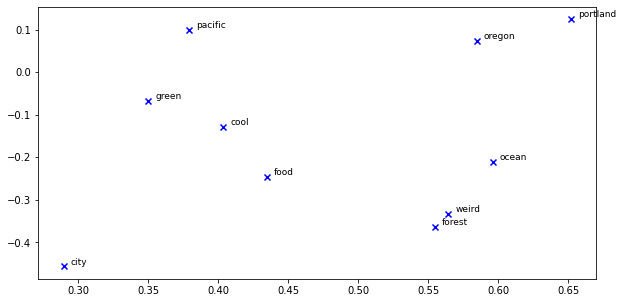

In [33]:
words = ['portland', 'pacific', 'forest', 'ocean', 'city', 'food', 'green', 'weird', 'cool', 'oregon']
plot_embeddings(M_reduced, word2ind, words)

#### <font color="red">Write your answer here.</font>

What clusters together in 2-dimensional embedding space?
* `weird` and `forest` appear to be close to eachother, which might be because of people have found forest to be weird and they used `weird` to descirbe `forest`.
* `portland` and `oregon` are clustered together, which makes sense.
* All other entities are scattered around the space.

What doesn't cluster together that you think should have?
* I believe `city` should also have been grouped along with `portland` and `oregon` yet it is on the opposite corner.
* `green` could have gone with `forest` or `oregon` or `city`
* `pacific` could have goouped with `ocean`.







### **Question 2.3**: GloVe Twitter Plot Analysis [written] (3 points)


In Section **Loading word vectors**, replace word2vec embeddings with GloVe Twitter 200-dimensional embeddings ''glove-twitter-200', and run all the cells again. 

And then run the cell below. What differences do you see in the GloVe embeddings as compared to word2vec embeddings?

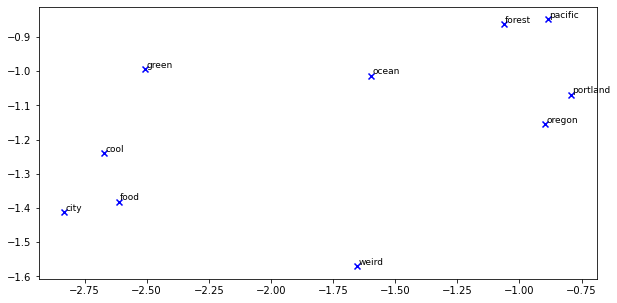

In [44]:
words = ['portland', 'pacific', 'forest', 'ocean', 'city', 'food', 'green', 'weird', 'cool', 'oregon']
plot_embeddings(M_reduced, word2ind, words)

#### <font color="red">Write your answer here.</font>

<font color="green"></font>

* `portland` and `oregon` are clustered closer in GloVe and that in word2vec.
* Unlike word2vec, `city` is closer to `food` and `cool` which makes more sense.

Overall, GloVe seems to have performed better than word2vec because the related entities are placed closer.

### **Note: For the following sections, you may choose to continue with GloVe embeddings, or reload the word2vec vectors.**

---




In [45]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Cosine Similarity
Now that we have word vectors, we need a way to quantify the similarity between individual words, according to these vectors. One such metric is cosine-similarity. We will be using this to find words that are "close" and "far" from one another.

We can think of n-dimensional vectors as points in n-dimensional space. If we take this perspective [L1](http://mathworld.wolfram.com/L1-Norm.html) and [L2](http://mathworld.wolfram.com/L2-Norm.html) Distances help quantify the amount of space "we must travel" to get between these two points. Another approach is to examine the angle between two vectors. From trigonometry we know that:

<img src="https://i.ibb.co/87Qscqh/inner-product.png" alt="inner-product" border="0">

Instead of computing the actual angle, we can compute the similarity in terms of $similarity = cos(\Theta)$. Formally the [Cosine Similarity](https://en.wikipedia.org/wiki/Cosine_similarity) $s$ between two vectors $p$ and $q$ is defined as:

$$s = \frac{p \cdot q}{||p|| ||q||}, \textrm{ where } s \in [-1, 1] $$ 

### **Question 3.1**: Words with Multiple Meanings  [code + written] (2 points)
Polysemes and homonyms are words that have more than one meaning (see this [wiki page](https://en.wikipedia.org/wiki/Polysemy) to learn more about the difference between polysemes and homonyms ). Find a word with *at least two different meanings* such that the top-10 most similar words (according to cosine similarity) contain related words from *both* meanings. For example, "leaves" has both "go_away" and "a_structure_of_a_plant" meaning in the top 10, and "scoop" has both "handed_waffle_cone" and "lowdown". You will probably need to try several polysemous or homonymic words before you find one. 

Please state the word you discover and the multiple meanings that occur in the top 10. Why do you think many of the polysemous or homonymic words you tried didn't work (i.e. the top-10 most similar words only contain **one** of the meanings of the words)?

**Note**: You should use the `wv_from_bin.most_similar(word)` function to get the top 10 similar words. This function ranks all other words in the vocabulary with respect to their cosine similarity to the given word. For further assistance, please check the __[GenSim documentation](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.FastTextKeyedVectors.most_similar)__.

In [46]:
# ------------------

wv_from_bin.most_similar('web')

# ------------------

[('website', 0.70011305809021),
 ('blog', 0.686927318572998),
 ('site', 0.6789528727531433),
 ('software', 0.6619877815246582),
 ('internet', 0.6602414846420288),
 ('online', 0.652936577796936),
 ('mobile', 0.6490216255187988),
 ('marketing', 0.6465798020362854),
 ('google', 0.6382794380187988),
 ('social', 0.6261212825775146)]

#### <font color="red">Write your answer here.</font>

<font color="green"></font>

* The meaning of `web` is related to more than 2 words on the list - `website`, `internet`, `google`, `social`, `mobile`, `online`

Why do you think many of the polysemous or homonymic words you tried didn't work?
* Actually I got the right word `web` at my first attempt, which is great.
* However, I tried other polysemous/homonymic words and they did not work. In my opinion, the reason for this might be that the corpus used to create the model does not have the these words used for differnet context and even if they have been used, their usage might be very rare.

### **Question 3.2**: Synonyms & Antonyms  [code + written] (2 points)

When considering Cosine Similarity, it's often more convenient to think of Cosine Distance, which is simply 1 - Cosine Similarity.

Find three words $(w_1,w_2,w_3)$ where $w_1$ and $w_2$ are synonyms and $w_1$ and $w_3$ are antonyms, but Cosine Distance $(w_1,w_3) <$ Cosine Distance $(w_1,w_2)$. 

As an example, $w_1$="happy" is closer to $w_3$="sad" than to $w_2$="excited". Please find a different example that satisfies the above. Once you have found your example, please give a possible explanation for why this counter-intuitive result may have happened.

You should use the the `wv_from_bin.distance(w1, w2)` function here in order to compute the cosine distance between two words. Please see the __[GenSim documentation](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.FastTextKeyedVectors.distance)__ for further assistance.

In [47]:
# ------------------
    
w1 = 'known'
w2 = 'familiar'
w3 = 'unknown'

print('Cosine Distance between w1 and w2: ', wv_from_bin.distance(w1, w2))
print('Cosine Distance between w1 and w3: ', wv_from_bin.distance(w1, w3))

# ------------------

Cosine Distance between w1 and w2:  0.6874304413795471
Cosine Distance between w1 and w3:  0.5049524009227753


#### <font color="red">Write your answer here.</font>

<font color="green"></font>

I can see that the consine similarity is more for the antonyms than for the corresponding synonyms. One of the reasons may be that the antonyms are used in the same context more frequently than the snyonyms in a same context.

### **Question 3.3**: Analogies with Word Vectors [written] (1 point)
Word vectors have been shown to *sometimes* exhibit the ability to solve analogies. 

As an example, for the analogy "man : king :: woman : x" (read: man is to king as woman is to x), what is x?

In the cell below, we show you how to use word vectors to find x using the `most_similar` function from the __[GenSim documentation](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.KeyedVectors.most_similar)__. The function finds words that are most similar to the words in the `positive` list and most dissimilar from the words in the `negative` list (while omitting the input words, which are often the most similar; see [this paper](https://www.aclweb.org/anthology/N18-2039.pdf)). The answer to the analogy will have the highest cosine similarity (largest returned numerical value).

In [48]:
# Run this cell to answer the analogy -- man : king :: woman : x
pprint.pprint(wv_from_bin.most_similar(positive=['woman', 'king'], negative=['man']))

[('queen', 0.6820898056030273),
 ('prince', 0.5875527262687683),
 ('princess', 0.5620489120483398),
 ('royal', 0.5522865056991577),
 ('mother', 0.5362966656684875),
 ('elizabeth', 0.5142495632171631),
 ('lady', 0.5010437369346619),
 ('lion', 0.4998807907104492),
 ('women', 0.4985954761505127),
 ('’s', 0.49350738525390625)]


Let $m$, $k$, $w$, and $x$ denote the word vectors for `man`, `king`, `woman`, and the answer, respectively. Using **only** vectors $m$, $k$, $w$, and the vector arithmetic operators $+$ and $-$ in your answer, what is the expression in which we are maximizing cosine similarity with $x$?

Hint: Recall that word vectors are simply multi-dimensional vectors that represent a word. It might help to draw out a 2D example using arbitrary locations of each vector. Where would `man` and `woman` lie in the coordinate plane relative to `king` and the answer?

#### <font color="red">Write your answer here.</font>

<font color="green"></font>

king - man + woman = queen

### **Question 3.4**: Finding Analogies [code + written]  (1 point)
Find an example of analogy that holds according to these vectors (i.e. the intended word is ranked top). In your solution please state the full analogy in the form x:y :: a:b. If you believe the analogy is complicated, explain why the analogy holds in one or two sentences.

**Note**: You may have to try many analogies to find one that works!

In [49]:
# ------------------

pprint.pprint(wv_from_bin.most_similar(positive=['turtle', 'fast'], negative=['deer']))

# ------------------

[('slow', 0.4855552017688751),
 ('quick', 0.46724921464920044),
 ('faster', 0.45864337682724),
 ('easy', 0.45563268661499023),
 ('turtles', 0.4447053372859955),
 ('back', 0.43254730105400085),
 ('smart', 0.42797502875328064),
 ('quickly', 0.42690128087997437),
 ('like', 0.4204716682434082),
 ('life', 0.41988658905029297)]


#### <font color="red">Write your answer here.</font>

<font color="green"></font>

```
x:y :: a:b = deer:fast ::  turtle:slow
```

I think it makes sense (not complicated).

### **Question 3.5**: Incorrect Analogy [code + written] (1 point)
Find an example of analogy that does *not* hold according to these vectors. In your solution, state the intended analogy in the form x:y :: a:b, and state the (incorrect) value of b according to the word vectors.

In [50]:
# ------------------

pprint.pprint(wv_from_bin.most_similar(positive=['turtle', 'swift'], negative=['deer']))

# ------------------

[('taylor', 0.6249005198478699),
 ('adele', 0.572992205619812),
 ('sheeran', 0.5592507719993591),
 ('miley', 0.5256857872009277),
 ('cyrus', 0.5229346752166748),
 ('ariana', 0.514667272567749),
 ('selena', 0.5076854228973389),
 ('rihanna', 0.4953581988811493),
 ('styles', 0.49425625801086426),
 ('carly', 0.48902207612991333)]


#### <font color="red">Write your answer here.</font>

<font color="green"></font>

```
x:y :: a:b = deer:swift ::  turtle:taylor
```

I am not sure if I should say this an incorrect analogy.

Actually my expectation was as deer is to swift, turtle is to slow/sluggish or somthing slowish. But, I got 'taylor'.

### **Question 3.6**: Guided Analysis of Bias in Word Vectors [written] (1 point)

It's important to be cognizant of the biases (gender, race, sexual orientation etc.) implicit in our word embeddings. Bias can be dangerous because it can reinforce stereotypes through applications that employ these models.

Run the cell below, to examine (a) which terms are most similar to "woman" and "worker" and most dissimilar to "man", and (b) which terms are most similar to "man" and "worker" and most dissimilar to "woman". Point out the difference between the list of female-associated words and the list of male-associated words, and explain how it is reflecting gender bias.

In [51]:
# Run this cell
# Here `positive` indicates the list of words to be similar to and `negative` indicates the list of words to be
# most dissimilar from.
pprint.pprint(wv_from_bin.most_similar(positive=['woman', 'worker'], negative=['man']))
print()
pprint.pprint(wv_from_bin.most_similar(positive=['man', 'worker'], negative=['woman']))

[('workers', 0.6558226943016052),
 ('employee', 0.6185225248336792),
 ('employees', 0.5715725421905518),
 ('harassment', 0.479827880859375),
 ('officer', 0.47716623544692993),
 ('customer', 0.4707619547843933),
 ('nurse', 0.4612693190574646),
 ('receptionist', 0.46062037348747253),
 ('representative', 0.45838046073913574),
 ('nurses', 0.4579216539859772)]

[('workers', 0.5465855002403259),
 ('manager', 0.49535703659057617),
 ('job', 0.4911527633666992),
 ('vet', 0.4808799624443054),
 ('staff', 0.4772389531135559),
 ('employee', 0.46296143531799316),
 ('officer', 0.45800548791885376),
 ('was', 0.44496333599090576),
 ('wages', 0.44081079959869385),
 ('construction', 0.4403908848762512)]


#### <font color="red">Write your answer here.</font>

<font color="green"></font>

I can see different results for male-associated words and female-associated words. The model does not expect woman to be `manager`, `staff`, `officer` or `employee` and man to be `nurse`, `receptionist`, `customer`, or `harassment`. This shows that the model does not want man to be a `nurse`, and woman to be a `manager`. In real world, these jobs are not essentially assigned for male or female. This shows that the model is a gender biased model.

### **Question 3.7**: Independent Analysis of Bias in Word Vectors [code + written]  (1 point)

Use the `most_similar` function to find another case where some bias is exhibited by the vectors. Please briefly explain the example of bias that you discover.

<b><font color="red">Disclaimer: Disturbing content ahead</font></b>

In [52]:
# ------------------

pprint.pprint(wv_from_bin.most_similar(positive=['mother', 'money'], negative=['father']))
print()
pprint.pprint(wv_from_bin.most_similar(positive=['father', 'money'], negative=['mother']))

# ------------------

[('cash', 0.6941454410552979),
 ('bitch', 0.6781004667282104),
 ('shit', 0.6571056842803955),
 ('fuck', 0.6553544402122498),
 ('pay', 0.6389952301979065),
 ('bitches', 0.6353094577789307),
 ('get', 0.6293692588806152),
 ('bad', 0.622443437576294),
 ('need', 0.6195367574691772),
 ('work', 0.6172423958778381)]

[('cash', 0.6942598819732666),
 ('paid', 0.6410634517669678),
 ('pay', 0.6364431381225586),
 ('wealth', 0.6071423292160034),
 ('rich', 0.5948802828788757),
 ('him', 0.5929766893386841),
 ('paying', 0.5899202227592468),
 ('dollars', 0.5775666236877441),
 ('spend', 0.5769830942153931),
 ('future', 0.5666353702545166)]


#### <font color="red">Write your answer here.</font>

<font color="green"></font>

I discovered that the model is too biased towards the role of `mother` and `father` regarding `money`. `mother` is associated with negative slangs whereas `father` is associated with paying positive things like `paying`, `wealth`, `rich`, and `future`.

### **Question 3.8**: Thinking About Bias [written] (2 points)

Give one explanation of how bias gets into the word vectors. What is an experiment that you could do to test for or to measure this source of bias?

#### <font color="red">Write your answer here.</font>

<font color="green"></font>

Give one explanation of how bias gets into the word vectors.
* This is obviously because of the corpus used to build the model, and the corpus comes form the based society.

What is an experiment that you could do to test for or to measure this source of bias?
* Present the corpus to the people of different background and ask them if the data is biased for them.

# <font color="blue"> Submission Instructions</font>

When you are satified with your results, you can submit this assignment by doing the following:

1. Click the Save button at the top of the Jupyter Notebook.

2. Add your name and PSU ID # at the top.

3. **For Colab**: 

(i) Select *Edit > Clear All Outputs*.

(ii) Click *Runtime > Restart and Run All*.


(iii) Click *File > Print* and print to PDF. Name the file hw#_[odin_userid].pdf (for example Homework 1 for John Doe might be hw1_jdoe.pdf)
   
3. **For Jupyter running on local machine**:

(i) Select *Cell -> All Output -> Clear*. This will clear all the outputs from all cells (but will keep the content of all cells).

(ii) Select *Cell -> Run All*. This will run all the cells in order, and will take several minutes.

(iii) Once you've rerun everything, select *File -> Download as -> PDF via LaTeX*.


4. Look at the PDF file and make sure all your solutions are there, displayed correctly.

5. Also download your .ipynb.

5. Submit both the PDF file and the Jupyter notebook (.ipynb) on D2L under *Activities > Assignment* under the appropriate assignment.